## NSMC로 감정 분석(텍스트 분류) 하기

![감정분석 다이어그램](figs/sentiment_analysis.jpg)

> Reference : https://www.kdnuggets.com/2018/03/5-things-sentiment-analysis-classification.html

### 1. 감정분석이란?

* Natural Language Processing, Text Analysis, Computational Lingustics, biometrics 같은 방법을 이용하여 텍스트에 숨겨져있는 저자의 의도나 정보를 찾아내는 모든 방법들을 말한다.
    - 감정분석을 general하게 정의 -> 텍스트안의 숨어있는 의미를 뽑아낸다!
    - 이 사람의 기분, 감정, 상태


* Opinion Mining, Sentiment Mining, Subjectivity Analysis 라고도 불리기도 한다.


* 초반의 방법들은 텍스트의 극성(Polarity)를 찾기 위해 많이 시도되었다. 대표적인 예로 <b>긍정/부정</b>으로 나누는 케이스가 있다.


* 감정 분석은 크게 Knowledge-based approach, Machine Learning-based approach가 있다.

> Knowledge-based는 알려진 어구, 어미, 관용 표현등을 활용하여 이미 문서들을 human expert가 평가한 데이터를 가져와 평가하는 방법이다.

> ML-based approach는 supervised, unsupervised 방법이 있다. 최근 pretrained Language Model이 비약적으로 발달함에 따라 unsupervised 방법의 성능도 많이 높아졌지만, 아직까지는 성능면에선 supervised가 월등히 높다.

* 따라서, 가장 많이 쓰이는 방법인 text classification으로서의 sentiment analysis를 공부해보고, 추가적으로 생각해볼 여러 가지 이슈에 대해 고민해보는 시간을 가진다.

<img src="figs/sentiment_diagram.png" width="500">

### 2. 텍스트 분류란?

* 벡터 형태로 표현된 텍스트를 말그대로 분류하는 방법이다.


* DNN이 비약적으로 성능 향상을 가져오기 전까지는 SVM이 가장 많이 사용되었다.


* 현재는 CNN, LSTM을 분류 모델로 가장 많이 사용한다.


* 실제로 텍스트 분류 작업은 큰 범위에서 대부분의 NLP downstream task를 포함한다.


* 하나의 예로, Siamese Network라는 걸 통해서 Question-Answering pair를 학습하게 되면, 분류의 기준이 "특정 질문에 맞는 정답을 잘 골랐는가 아닌가(0 / 1)"를 해결하는 문제로 바뀌게 된다.

<문제정의></br></br>
- 따라서 우리는 NSMC를 감정분석 하기 위해 text classification을 쓴다
- 문서들이 있으면 어떤 문서인지 분류하는게 text classification인데, 이걸 확장해서 0과 1로 부정/긍정을 나눠보겠다

<img src="figs/text_classification.png" width="400">

### 3. scikit-learn으로 NSMC 감정분석 하기

* 저번 시간에 했던 코드를 그대로 가져와, nsmc를 불러옵니다.
* 조금 수정할 것임
    - scikit-learn으로 NSMC 분류하는 모델 만들 때, text classificatino할 때 어떤 방식을 써야 성능이 점진적으로 올라가는지 보여주려고 여러가지 방식으로 학습할 예정
    - 학습할 때 들어가는 차이 -> 명사쓸 건지, 정제를 다 날릴건지 그냥 쓸 건지, feature를 다 쓸 건지 몇개 뽑아 쓸 건지 등등 text를 벡터로 만들어서 쓸 때 이런 조합을 고려해야해
    - 그리고 이 다음엔 linear classifier를 쓸 건지 SVM을 쓸 건지 등등
    - 더 뒤로 딥러닝 기법으로 가면 어떤 임베딩 벡터쓸 건지 또는 text 자체를 넣어서 LSTM에 학습을 바로 시킬 건지, layer를 몇 개 쓸건지 하이퍼 파라미터 튜닝 등등
    - 하이퍼 파라미터 내부에도 어떤 adam optimizer를 쓸 건지 (최적화 기법?)
    - 모델마다 어떻게 text 분류 모델의 성능을 높이는 지 차이가 있음

In [2]:
def read_documents(filename):
    with open(filename, encoding='utf-8') as f:
        documents = [line.split('\t') for line in f.read().splitlines()]
        documents = documents[1:]
        
    return documents
    
train_docs = read_documents("data/nsmc/ratings_train.txt")
test_docs = read_documents("data/nsmc/ratings_test.txt")

In [3]:
print(len(train_docs))
print(len(test_docs))

150000
50000


In [4]:
def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
        
    return doc

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding='utf-8') as f:
        for word in f:
            SW.add(word)
            
    return SW

def text_tokenizing(doc):
    # 지금은 형태소 분석 기준
    return [word for word in mecab.morphs(doc) if word not in SW and len(word) > 1]
    
    # wordcloud를 위해 명사만 추출하는 경우.
    # return [word for word in mecab.nouns(doc) if word not in SW and len(word) > 1]

* 불러온 데이터를 품사 태그를 붙여서 토크나이징합니다.

In [5]:
from konlpy.tag import Mecab
from konlpy.tag import Okt # 실제로 안 쓰는 걸 추천
import json
import os
import re
from pprint import pprint

okt = Okt()
mecab = Mecab(dicpath="C:\\mecab\\mecab-ko-dic")

SW = define_stopwords("data/stopwords-ko.txt")

if os.path.exists('train_docs.json'):
    with open("train_docs.json", encoding='utf-8') as f:
        train_data = json.load(f)
else:
    # 저번에는 그냥 text_tokenizing하고 끝났다면 이번엔 text_cleaning까지 넣어서 해보는 코드
    
    # train_docs 형태 : ID \t 리뷰 \t label
    # \t으로 split해서 리스트 형태로 가져온 상태
   
    # trian_data를 2가지 버전으로 만들기. 1) 정제하기   2) 정제 안하기
    train_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in train_docs if text_tokenizing(text_cleaning(line[1]))]
    # (line[1], line[2]): str과 lable을 튜플을 원소로 하는 리스트가 됨
    # text_tokenizing(text_cleaning(line[1]) :if만족하면 for문 앞에 적용 -> 즉, 만약 text_tokenizing한 결과가 없으면 넣지마라 -> cleaning에서도 마찬가지로 빈 리스트 반환할 수 있으니 얘도 해주기!
    # 명사추출한 경우에는 리뷰데이터에는 ..., ㅋㅋ, ㅎㅎ같은 경우는 날라가기때문에 빈 리스트 반환 -> 뒤에서 vectorizaiton할 때 에러날 수 있으니 미리 제거
    
    # cleaning을 하고 tokenizing을 하나, tokenizing을 하고 cleaning을 하나 결과는 똑같은데, 속도와 코딩면에서 cleaning을 먼저 하는 게 좋다!
    
    with open("train_docs.json", 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=False, indent='\t')
        
if os.path.exists('test_docs.json'):
    with open("test_docs.json", encoding='utf-8') as f:
        test_data = json.load(f)
else:
    test_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in test_docs if text_tokenizing(text_cleaning(line[1]))]
    #test_data = [(text_tokenizing(line[1]), line[2]) for line in test_docs if text_tokenizing(line[1])]
    with open("test_docs.json", 'w', encoding='utf-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent='\t')

pprint(train_data[0])
pprint(test_data[0])

[['짜증', '목소리'], '0']
[['평점'], '0']


In [6]:
print(train_data[:3])

[[['짜증', '목소리'], '0'], [['포스터', '초딩', '영화', '오버', '연기'], '1'], [['교도소', '이야기', '재미', '평점', '조정'], '0']]


In [7]:
print(len(train_docs) - len(train_data))
print(len(test_docs) - len(test_data))
# 정제하고 사라진 데이터 개수를 알 수 있음

15115
4966


* 데이터 분석을 하기 위해 기본적인 정보들을 확인합니다.

* nltk 라이브러리를 이용하여 전처리를 합니다.

In [8]:
import nltk

total_tokens = [token for doc in train_data for token in doc[0]]
print(len(total_tokens))

601169


In [9]:
text = nltk.Text(total_tokens, name='NMSC')
print(len(set(text.tokens)))
pprint(text.vocab().most_common(10))

30917
[('영화', 57614),
 ('연기', 6835),
 ('최고', 6595),
 ('평점', 6297),
 ('스토리', 5422),
 ('드라마', 5192),
 ('생각', 5168),
 ('사람', 5035),
 ('감동', 4860),
 ('배우', 4450)]


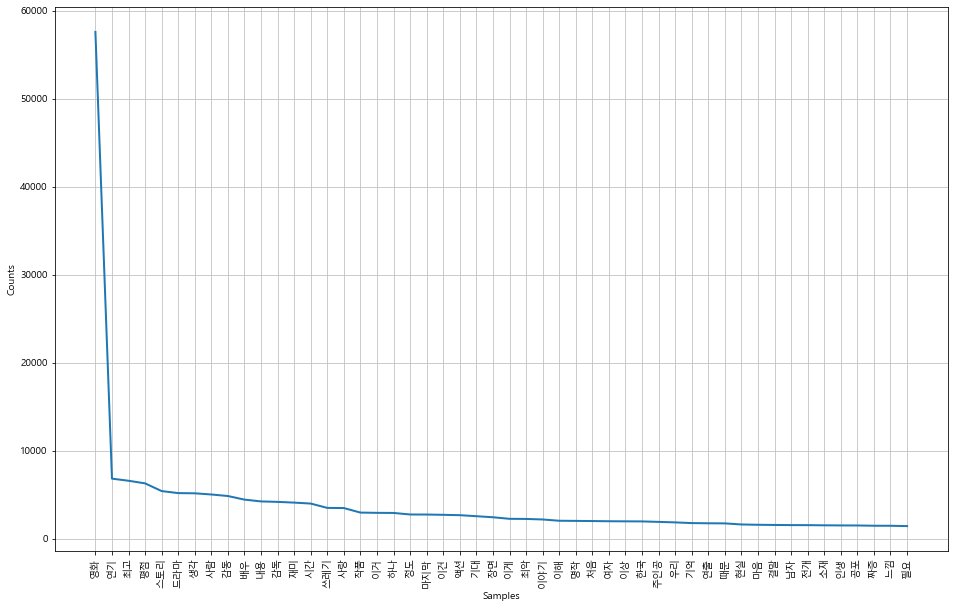

In [10]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

plt.figure(figsize=(16, 10))
text.plot(50)

In [11]:
# 여러 리스트들을 하나로 묶어 주는 함수입니다.
def list_to_str(List): 
    return " ".join(List)

# 이 함수 왜 정의했냐면, 실제로 skicit-learn의 CounterVecterizier를 쓸건데 기본적으로 input이 string!
# 안에 옵션 줄 수도 있는데 강사님은 귀찮아서 이렇게 쓴대
# 실제로 옵션으로 split안해도 된다고 줘도되지만 이렇게 해놓고 쓰면 list 데이터를 가지고 넣어줄 때 str으로 넣어주면 끝이라서/

### 4. Linear Classifier와 Support Vector Machine으로 nsmc 분류하기

In [14]:
# Linear classification에 필요한 라이브러리 불러오기
from sklearn.pipeline import Pipeline # 편하게 learner들 만들 수 있다
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import numpy as np

# 학습을 위해 데이터셋 모양 통일하기
train_x = [list_to_str(doc) for doc, _ in train_data] # doc는 현재 tokenizied된 리스트,
test_x = [list_to_str(doc) for doc, _ in test_data]
# doc, _ : 리스트와 label을 현재 가지고 있는데 우리가 쓸 건 doc이니까 label은 그냥 _처리
train_y = [label for _, label in train_data]
test_y = [label for _, label in test_data]

# 학습 모델 파이프라인 만들기

# 1. Perceptron linear classifier (W^Tx + b)
learner = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SGDClassifier(loss='perceptron', penalty='l2', # loss='perceptron': 우리가 알고있는 1차식(linear)
                         alpha=1e-4, random_state=42, # 파라미터들은 다 기본셋팅이라 생각해 안써도 무방
                         max_iter=100)) # 성능을 높이고싶다면 loss='perceptron'이라면 penalty랑 alpha값 조정할 수 있고, max_iter은 올려도돼(수렴이 안됐다면 더 돌릴 수 있겠지)
])

# 총 4개의 SVC
# 2. SVM with linear kernel
learner2 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='linear')) 
    # 데이터에 noise가 껴있거나 데이터 분포가 선형으로 분류가 불가능한 것이더라도 kernel을 쓰면 선형이 되는 공간으로 옴(머신러닝에서 kernel이라는 공간변환기법쓰는 이유)
    # 단점 : 어떤 kernel을 써야 성능이 가장 좋은지 알 수 없음(해봐야 암), 데이터 분포를 잘 안다면 사용할 수 있는데 대부분 고차원의 데이터 분포를 자세하게 알 수 있을리가 없지
    # tsn이나 pca 등 차원 축소에서 visualization은 할 수 있지만 그거랑 고차원의 분포랑은 다름
    # 상대적인 거리를 비교해서 저차원으로 본 것이긴 하고 저차원에서 잘 뭉쳐있으면 고차원에서도 잘 뭉쳐있지만, 그게 아니라면 어떤 분포인지 알 수 없기때문에 어떤 커널을 써야하는 지도 알 수 없음 (이것저것 다 해보는 게 최고..)
]) 

# 3. SVM with polynomial kernel
learner3 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='poly', degree=8)) # polynomial kernel을 쓰려면 degree도 줘야 함(총 몇 차원의 polynomial을 쓸 거냐)
]) # 8차원 준 이유는 이 degree도 정해진 게 없어서 높이면 높일 수록 오래 걸리는 대신에 좀 더 많이 구분함

# 4. SVM with Radius Basis Function kernel
leaner4 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='rbf'))
])

# 5. SVM with sigmoid kernel
leaner5 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='sigmoid'))
])
# 이 4개의 SVM의 차이점을 각각 알고있으면 좋지만, 텍스트 분류에서 linear가 좋냐 poly가 좋냐 등은 알 수 없어
# 왜냐면 일단 텍스트 분류 중에서도 벡터스페이스 모델의 가장 큰 단점이 고차원 공간이 굉장히 초고차원 공간임!(4만차원, 5만차원)
# 데이터가 만약 100만개, 1억개라고하면 벡터스페이스에서 차원이 답도 없이 크게나와서 linear나 poly냐 상관x 그리고 SVM 너무 오래 걸려4
# 그래서 초고차원은 문제가 있고 실제로 그만큼 정보를 담고있지않아서 보통 벡터의 차원을 내려버림
# 그래서 이론적으로 고차원 데이터에서 어떠 커널이 정확하게 동작하는지는 알기는 힘들다! 그래서 커널 여러개를 실제로 써보는 게 방법

# 6. Naive Bayes Classifier (Multinomial Ver.)
leaner6 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
]) # 나이브베이즈도 굉장히 좋은 방법임. 독립이다라는 조건만 안 깨지면 성능이 좋음
# 이게 되게 신기한게 벡터 스페이스 모델은 모든 단어의 독립성을 근거로 만들어진 벡터 표현
# 각 단어 단어가 독립이라는 가정을 깔고간다는 것은 단어와 단어가 서로 확률에 영향을 주지 않는다는 가정 -> 그러면 분리해서 쓸 수 있으니까 
# 벡터 스페이스 모델은 모든 단어 간의 word order와 coreference를 다 부셔버리고 벡터로 가나다 순 정렬을 해버렸으니까 독립성이 보장된거지
# 근데 그게 문제지! 지금은 문제라는 것을 알고 있으니까 나이브베이즈를 잘 안 쓰지
# 특히 언어모델의 딥러닝 기법에 오면서 n-gram을 쓴 이유가, 단어가 어떤 단어와 함께 나오냐가 제일 중요한 데 그걸 날려버렸으니까 성능 저하의 원인 중 하나라는 거지
# 근데 나이브베이즈 모델은 벡터 스페이스 모델에선 성능이 파워풀하다! 독립성을 보장한 것이기 때문에
# 바꿔말해 벡터 스페이스 모델에서 분류가 좀 잘 되는 데이터라고한다면 나이브베이즈를 쓰는 것도 좋은 방법


# 학습기 정하기
classifier = learner2

# 학습
classifier.fit(train_x, train_y)
train_predict = classifier.predict(train_x) # 엄밀히 따지면 validation까지 해줘야하는데 지금은 그정도 task는 아니라서..
train_accuracy = np.mean(train_predict == train_y) # 하나의 공식 => 정확도는 전체 중에 몇개를 맞았냐니까 전체 갯수 중에서 내가 predict한 결과와 실제 train의 label이 똑같은 개수를 mean => 정확도(%)

test_predict = classifier.predict(test_x)
test_accuracy = np.mean(test_predict == test_y)

# 테스트 및 성능 측정
print("For %d test data" % len(test_x))
print("Training Accuracy : %.2f" % train_accuracy)
print("Test Accuracy : %.2f" % test_accuracy)

For 45034 test data
Training Accuracy : 0.81
Test Accuracy : 0.74


In [10]:
# 강사님 코드 & 분석 결과
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import numpy as np

train_x = [list_to_str(doc) for doc, _ in train_data]
test_x = [list_to_str(doc) for doc, _ in test_data]
train_y = [label for _, label in train_data]
test_y = [label for _, label in test_data]

#print(len(train_x), len(train_y))
print("For %d train data" % len(train_x))
#print(len(test_x), len(test_y))

learner = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SGDClassifier(loss='perceptron', penalty='l2',
                         alpha=1e-4, random_state=42,
                         max_iter=100))
])

learner2 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='linear'))
    
])

learner3 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='poly', degree=8))
])

learner4 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='rbf'))
])

learner5 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='sigmoid'))
])

learner6 = Pipeline([
    ('vect', CountVectorizer()),
    ('mb', MultinomialNB())
])

classifier = learner2


classifier.fit(train_x, train_y)
train_predict = classifier.predict(train_x)
train_accuracy = np.mean(train_predict == train_y)

test_predict = classifier.predict(test_x)
test_accuracy = np.mean(test_predict == test_y)


print("For %d test data" % len(test_x))

print("Training Accuracy : %.2f" % train_accuracy)
print("Test Accuracy : %.2f" % test_accuracy)

For 148039 train data
For 49343 test data
Training Accuracy : 0.89
Test Accuracy : 0.81


### < 실험결과 >

#### Linear Classifier 학습하여, test accuracy를 측정. (learner)

1. 명사만 추출 : 0.51
2. 전처리 하지 않고 형태소 분석 : 0.67
3. 전처리(cleaning) 하고 형태소 분석 : 0.71

-----------여기까진 top 500 features만 사용-----------
- CountVectorizer(max_features=500) -> 자르면 성능 내려가는 모습
    - 이유는 약 49000개의 고차원인데 linear만 하더라도 500개만 쓰면 좋을 것이라 예상했었지만 실제로 안 좋았더라 (500개면 너무 작아, 다른걸로 min_df : 하위 몇개 짜르기 이런거 쓰면 아마 의미있어서 성능 좋을거야)
    - ex. CountVectorizer(min_df=5)) : 전체 문서에서 5번 이하 등장한 단어는 빼버리겠다
4. 3 + 모든 feature : 0.76

### < 실험결과 >

#### SVM Classifier 학습하여, test accuracy를 측정. (learner2)

1. 명사만 추출 : 0.53
2. 전처리 하지 않고 형태소 분석 : 0.72
3. 전처리 하고 형태소 분석 : 0.77

-----여기까진 top 500 features만 사용--------
4. 3 + 모든 feature : 0.81
    - 명사 추출했을 때는 SVM써도 큰 차이가 없지 => 벡터 표현 자체가 불확실해서
        - accuracy가 0.5에 가깝다는 것은 찍고있다는 얘기지(binary classification, 망한거)
    - 얻을 수 있는 첫번째 결론은 명사만 쓰는게 분류문제(정확히 NSMC 데이터)에서 그렇게 큰 정보를 주지 못한다
    - 전처리를 하고 안 하고에 대해서 성능이 비교가 되지
        - NSMC데이터에선 특수문자가 굉장히 많으니까 특수문자를 빼버리는 게 토큰을 좀 더 단일화로 만들어줌(text normalization - 텍스트 표현을 합쳐주는 것)
        - ex. 괄호표현되어있던 것들, 쉼표, 마침표 등 다 떼어지면서 토큰들이 좀 모이면 성능이 좀 더 올라갈 수 있다
    - top 500으로 자르는 것 보다 모든 feature 쓰면 더 좋더라
    

- (강사님 추천 1) CountVectorizer랑 TFIDF Vectorizer 둘 중에 어떤 게 더 좋을까?
- (강사님 추천 2) CountVectorizer에서 feature를 selectoin하는 방법 중에서 max_feature쓰는 방법이 있었고 min_df 쓰는 방법이 있었는데, 어떻게 뽑았을 때가 제일 좋을까
- (강사님 추천 3) SVM의 경우 파라미터가 여러개 있는데, 어떻게 하면 best 하이퍼파라미터일까